In [47]:
from PIL import Image
from matplotlib.pylab import *
from matplotlib import pyplot as plt
import numpy as np
import cv2
from collections import defaultdict

1. Считать цветное rgb изображение

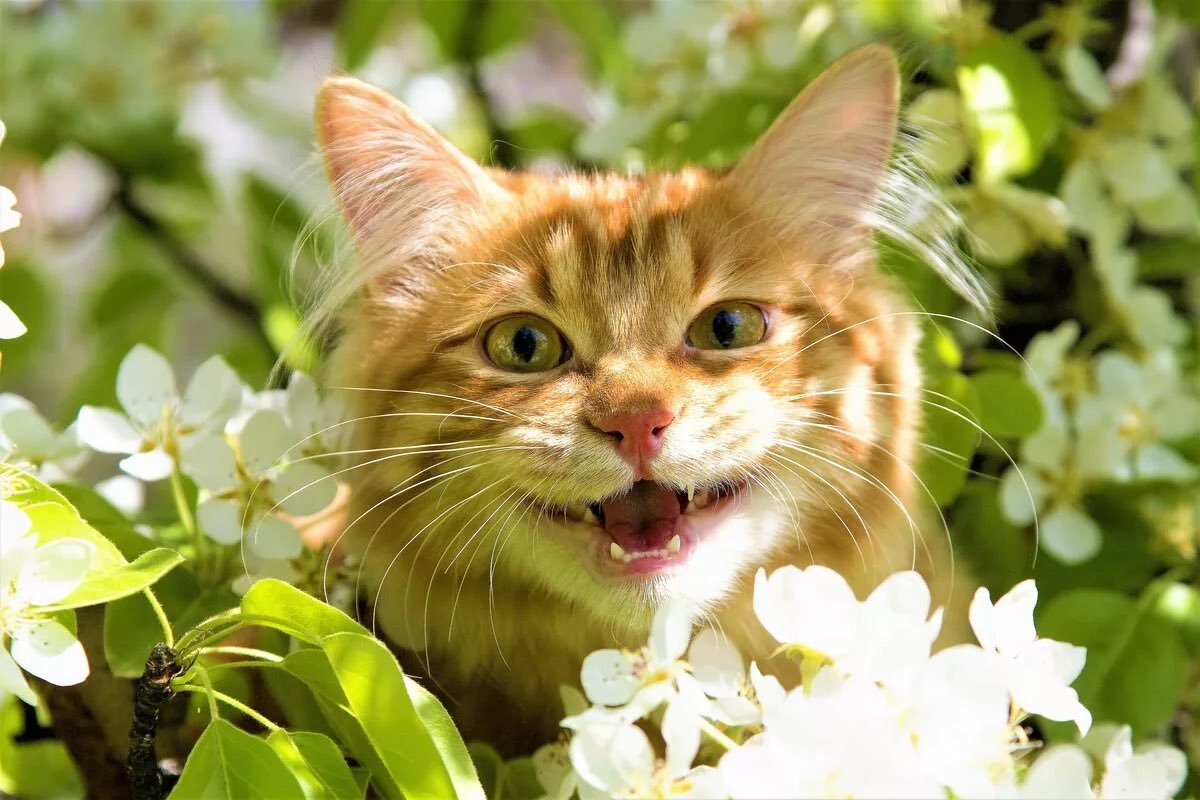

In [2]:
IMG_PATH = "C:\\Users\\Vladislav\\Desktop\\ImgProcessingSystems\\kitty2.jpg"

image = Image.open(IMG_PATH)
image

In [3]:
np.array(image).shape

(800, 1200, 3)

2. Преобразовать изображение в градации серого

Формула преобразования: __Y = 0.2126 * R + 0.7152 * G + 0.0722 * B__

In [16]:
def img_to_grayscale(rgb_img) -> np.ndarray:
    img_array = np.array(rgb_img)
    rows, cols, _ = img_array.shape
    img_grayscale = np.zeros((rows, cols))
    for i,j in np.ndindex((rows, cols)):
        img_grayscale[i, j] = int(0.2126 * img_array[i, j][0] + 0.7152 * img_array[i, j][1] + 0.0722 * img_array[i, j][2])
    return img_grayscale.astype(np.uint8)

In [17]:
img_gray = img_to_grayscale(image)

In [18]:
%matplotlib inline

In [19]:
def plt_show_image(image, is_gray = True):
    axis("off")
    imshow(image, cmap = plt.get_cmap('gray') if is_gray else None)

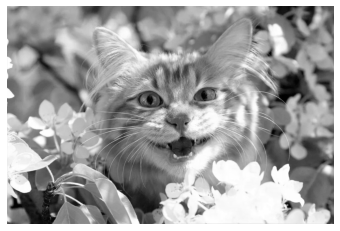

In [20]:
plt_show_image(img_gray)

3. Написать функцию реализации препарирования изображения

In [73]:
# def img_prepare(x, l = 63, u = 192):
#     if l < x < u:
#         return (x*2) - 128
#     else:
#         return 127
def img_prepare_func(x, l = 51, u = 204):
    if l < x < u:
        return ((x - l) * 255) / 153
    else:
        return 127

Гистограмма функции:

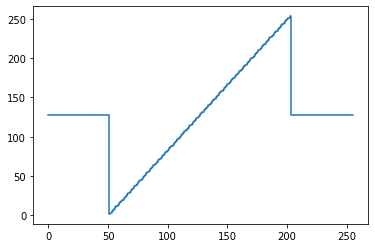

In [74]:
x_list = range(0, 256)
y_list = [img_prepare_func(x) for x in x_list]
plt.step(x_list, y_list)

4. По гистограмме изображения определить значение порога яркостей, обеспечивающего оптимальное разделение объекта и фона. Осуществить пороговую обработку входного изображения с найденным пороговым значением:

    - __Вход__: изображение из пункта 2
    - __Выход__: входное и результирующие изображение и их гистограммы соответственно
    - Порог определить на глаз по гистограмме

In [28]:
def get_values_and_plot(img_grayscale, plot_title = None, nbr_bins = 256, plot_cdf = False):
    if len(img_grayscale.shape) < 2:
        return
    figure(figsize=(10, 5))
    if plot_title:
        title(plot_title)
    img_hist, bins = np.histogram(img_grayscale.flatten(), nbr_bins, [0, 256])
    cdf = img_hist.cumsum()
    norm_cdf = cdf * float(img_hist.max()) / cdf.max()
    if plot_cdf:
        plot(norm_cdf, color='b')
        hist(img_grayscale.flatten(), nbr_bins, [0, 256], color='r')
        xlim([0, 256])
        legend(("Функция распределения", "Гистограмма"), loc="upper left")
    else:
        hist(img_grayscale.flatten(), bins=nbr_bins, density=True)
    grid(True)
    show()
    return img_hist, bins, cdf, norm_cdf

In [29]:
def threshold_prep(img_grayscale, threshold = 100):
    """Функция, выполняющая пороговую обработку."""
    rows, cols = img_grayscale.shape
    img_threshold = np.zeros((rows, cols))
    for i,j in np.ndindex((rows, cols)):
        img_threshold[i, j] = img_grayscale[i, j] if img_grayscale[i, j] > threshold else 0
    get_values_and_plot(img_threshold, plot_title="Гистограмма после пороговой обработки")
    return img_threshold

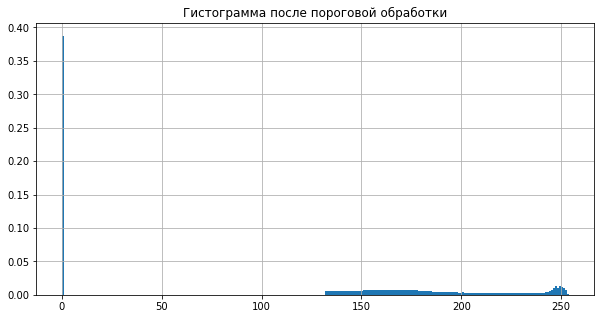

In [45]:
img_threshold = threshold_prep(img_gray, threshold=131)

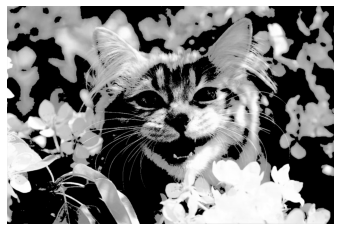

In [46]:
plt_show_image(img_threshold)

In [53]:
def linear_contrast(img_grayscale):
    results = defaultdict(lambda: None)

    flatten_image = img_grayscale.flatten()
    x_min = flatten_image.min()
    x_max = flatten_image.max()
    results["original_range"] = (x_min, x_max)
    results["original_image"] = img_grayscale.copy()

    y_min = 0
    y_max = 255
    a = (y_max - y_min) / (x_max - x_min)
    b = (y_min * x_max - y_max * x_min) / (x_max - x_min)
    results["a"] = a
    results["b"] = b

    rows, cols = img_grayscale.shape
    img_result = np.zeros((rows, cols))

    for i,j in np.ndindex((rows, cols)):
        img_result[i, j] = int(a * img_grayscale[i, j] + b)

    img_result = img_result.astype(np.uint8)

    flatten_img_result = img_result.flatten()
    results["result_range"] = (flatten_img_result.min(), flatten_img_result.max())
    results["result_image"] = img_result.copy()

    return results

In [58]:
linear_contrast_result = linear_contrast(img_gray)

In [59]:
print("Линейное преобразование для данного изображения: f =", linear_contrast_result['a'], "* x +", linear_contrast_result['b'])

Линейное преобразование для данного изображения: f = 1.0039370078740157 * x + 0.0


Динамический диапазон исходного изображения: (0, 254)


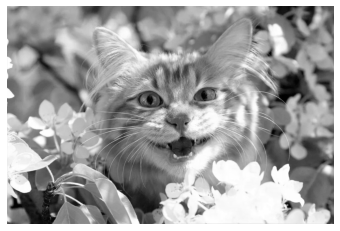

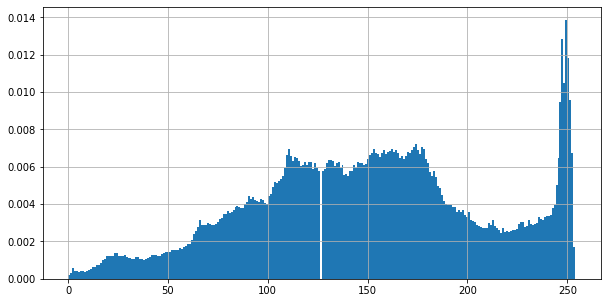

(array([  207,   314,   531,   416,   394,   361,   403,   412,   370,
          419,   471,   493,   584,   606,   685,   724,   815,   967,
          994,  1140,  1143,  1139,  1153,  1300,  1312,  1151,  1181,
         1149,  1190,  1111,  1070,  1038,   999,  1013,  1088,  1101,
         1022,  1012,   967,  1003,  1066,  1107,  1214,  1226,  1214,
         1149,  1161,  1252,  1320,  1348,  1393,  1382,  1486,  1479,
         1480,  1491,  1559,  1498,  1640,  1663,  1755,  1789,  1999,
         2268,  2439,  2643,  3017,  2753,  2755,  2738,  2829,  2773,
         2768,  2764,  2801,  2919,  3067,  3121,  3286,  3315,  3475,
         3368,  3389,  3488,  3662,  3708,  3646,  3621,  3606,  3818,
         3897,  4230,  4091,  4186,  3999,  3954,  3944,  4073,  4010,
         3863,  3802,  4202,  4336,  4698,  4963,  4870,  5008,  5091,
         5258,  5653,  6301,  6636,  6242,  5986,  6193,  6161,  6011,
         5741,  5814,  5939,  5788,  5935,  5940,  5626,  5897,  5631,
      

In [60]:
print("Динамический диапазон исходного изображения:", linear_contrast_result['original_range'])
plt_show_image(linear_contrast_result['original_image'])
get_values_and_plot(linear_contrast_result['original_image'])

Динамический диапазон после линейного контрастирования: (0, 255)


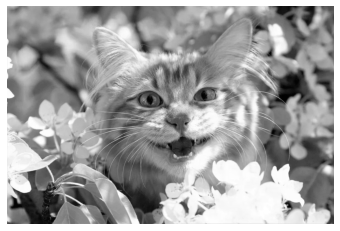

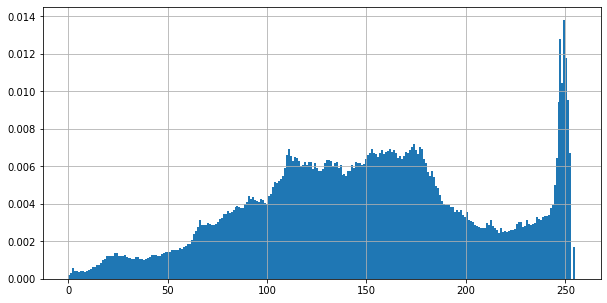

(array([  207,   314,   531,   416,   394,   361,   403,   412,   370,
          419,   471,   493,   584,   606,   685,   724,   815,   967,
          994,  1140,  1143,  1139,  1153,  1300,  1312,  1151,  1181,
         1149,  1190,  1111,  1070,  1038,   999,  1013,  1088,  1101,
         1022,  1012,   967,  1003,  1066,  1107,  1214,  1226,  1214,
         1149,  1161,  1252,  1320,  1348,  1393,  1382,  1486,  1479,
         1480,  1491,  1559,  1498,  1640,  1663,  1755,  1789,  1999,
         2268,  2439,  2643,  3017,  2753,  2755,  2738,  2829,  2773,
         2768,  2764,  2801,  2919,  3067,  3121,  3286,  3315,  3475,
         3368,  3389,  3488,  3662,  3708,  3646,  3621,  3606,  3818,
         3897,  4230,  4091,  4186,  3999,  3954,  3944,  4073,  4010,
         3863,  3802,  4202,  4336,  4698,  4963,  4870,  5008,  5091,
         5258,  5653,  6301,  6636,  6242,  5986,  6193,  6161,  6011,
         5741,  5814,  5939,  5788,  5935,  5940,  5626,  5897,  5631,
      

In [62]:
print("Динамический диапазон после линейного контрастирования:", linear_contrast_result['result_range'])
plt_show_image(linear_contrast_result['result_image'])
get_values_and_plot(linear_contrast_result['result_image'])

7. Сделать эквализацию гистограммы изображения

    - __Вход__: изображение из пункта 2
    - __Выход__: входное и результирующие изображение и их гистограммы соответственно

In [66]:
def img_eq(img_grayscale):
    img_hist, bins, cdf, norm_cdf = get_values_and_plot(img_grayscale, plot_title="Гистограмма и функция распределения исходного изображения", plot_cdf=True)
    cdf_mask = np.ma.masked_equal(cdf, 0)
    cdf_mask = ((cdf_mask - cdf_mask.min()) * 255 / (cdf_mask.max() - cdf_mask.min()))
    result_cdf = np.ma.filled(cdf_mask, 0).astype(np.uint8)
    result_img = result_cdf[img_grayscale]
    get_values_and_plot(result_img, plot_title="Гистограмма и функция распределения эквализированного изображения", plot_cdf=True)
    return result_img

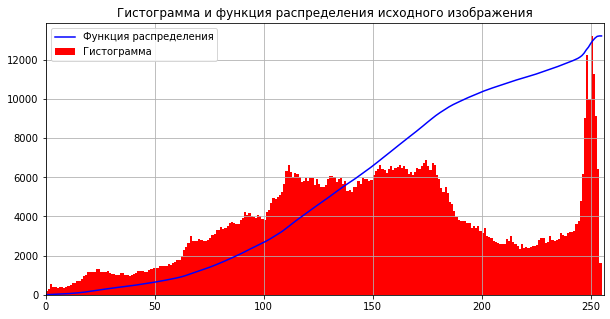

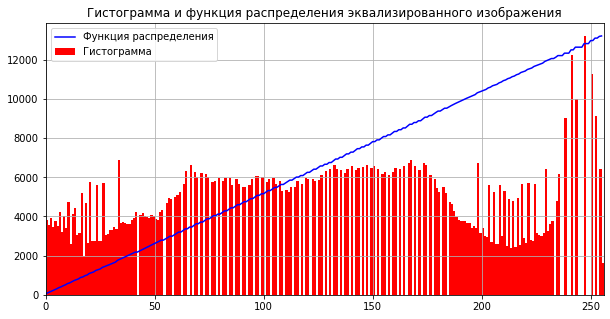

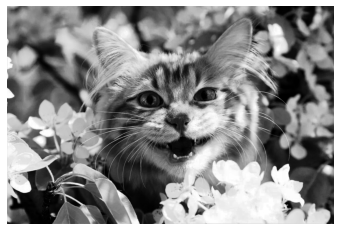

In [67]:
img_equal = img_eq(img_gray)
plt_show_image(img_equal)

8. Сделать эквализацию методом CLAHE (Функция OpenCV)

    - __Вход__: изображение из пункта 2
    - __Выход__: входное и результирующие изображение и их гистограммы соответственно

In [68]:
img_equal_opencv = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(img_gray)

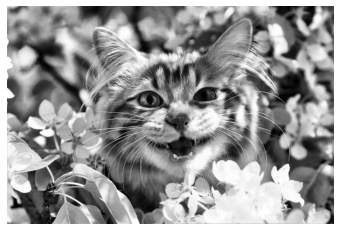

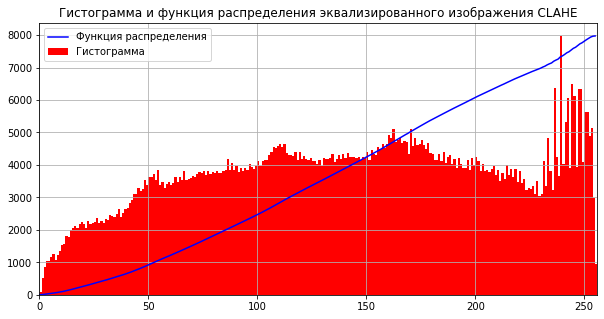

(array([  83,  526,  850, 1026, 1043, 1168, 1245, 1070, 1213, 1358, 1543,
        1578, 1823, 1781, 1984, 2043, 2113, 2055, 2179, 2251, 2174, 2053,
        2287, 2179, 2225, 2248, 2373, 2205, 2284, 2202, 2330, 2303, 2459,
        2430, 2393, 2495, 2656, 2411, 2523, 2651, 2689, 2839, 2927, 3102,
        3117, 3289, 3187, 3261, 3537, 3389, 3643, 3626, 3736, 3524, 3833,
        3387, 3484, 3289, 3410, 3467, 3386, 3440, 3621, 3467, 3642, 3528,
        3817, 3524, 3563, 3609, 3646, 3622, 3723, 3788, 3750, 3805, 3704,
        3823, 3725, 3768, 3747, 3824, 3750, 3761, 3813, 3852, 4172, 3843,
        4056, 3845, 3960, 3774, 3892, 3812, 3905, 3833, 4021, 3933, 3889,
        3970, 4118, 3977, 4134, 4158, 4148, 4308, 4403, 4560, 4521, 4576,
        4653, 4546, 4642, 4375, 4304, 4310, 4266, 4389, 4164, 4385, 4193,
        4283, 4186, 4165, 4207, 4132, 4130, 4029, 4144, 3981, 4212, 4174,
        4181, 4202, 4324, 4104, 4197, 4295, 4198, 4326, 4218, 4364, 4249,
        4233, 4245, 4222, 4247, 4166, 

In [70]:
plt_show_image(img_equal_opencv)
get_values_and_plot(img_equal_opencv, plot_title="Гистограмма и функция распределения эквализированного изображения CLAHE", plot_cdf=True)

9. Осуществить препарирование изображения с заданной препарирующей функцией

    - __Вход__: изображение из пункта 2
    - __Выход__: входное и результирующие изображение и их гистограммы соответственно. График препарирующий функции.
    - Пороги в препарирующей функции выбирать самостоятельно

In [71]:
def img_preparation(img_grayscale):
    rows, cols = img_grayscale.shape
    new_img = np.zeros((rows, cols))
    for i,j in np.ndindex((rows, cols)):
        x = img_grayscale[i, j]
        new_img[i, j] = img_prepare_func(x)
    get_values_and_plot(new_img, plot_title="Гистограмма препарированного изображения")
    return new_img.astype(np.uint8)

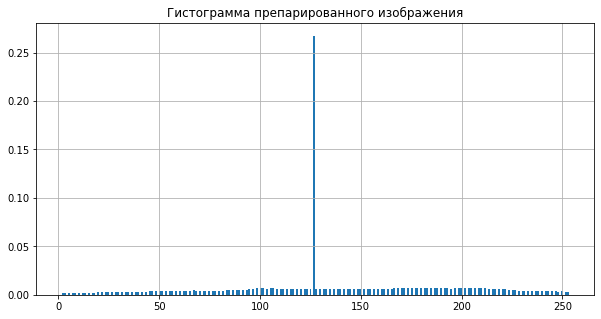

In [75]:
img_prepared = img_preparation(img_gray)

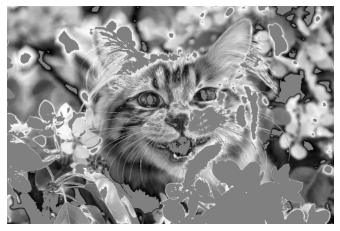

In [77]:
plt_show_image(img_prepared)